In [1]:
%matplotlib notebook 

import numpy as np

import matplotlib.ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sunpy.map
import sunpy.data.sample
from sunpy.net import Fido, attrs as a
from sunpy.coordinates import Helioprojective, RotatedSunFrame, transform_with_sun_center
from sunpy.map.maputils import all_coordinates_from_map, coordinate_is_on_solar_disk
from sunpy.io import write_file
from sunpy.time import parse_time

import astropy.units as u
from astropy.coordinates import SkyCoord, ICRS
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

from reproject import reproject_interp
from aiapy.calibrate import register, update_pointing
from aiapy.calibrate.util import get_pointing_table
from scipy.io import loadmat
from scipy import ndimage
import os, sys
import copy
from PIL import Image
import datetime
import math
from math import sin, cos, asin, acos, atan, sqrt
import pandas as pd
  
import cv2

%run ./functions.ipynb

In [2]:
#############################################################################
#@title Surface area Function (for sunpy maps)

#############################################################################
def surface_area(masked_map):
    
    ## Useful information
    R_pix= masked_map.meta['rsun_obs']/masked_map.meta['cdelt1'] # sun radius in pixels
    rad=int(R_pix)
    R_km= masked_map.meta['rsun_ref']*10**(-3) # sun radius in km
    # Note that CRPIXn follows the Fortran convention of counting from 1 to N,
    #instead of from 0 to N − 1 as is done in some programming languages.
    cenX= int(masked_map.meta['crpix1']) # X axis reference pixel 
    cenY= int(masked_map.meta['crpix2']) # Y axis reference pixel
#     print('cenX: ', cenX, ', cenY: ', cenY, ', R_SUN [arcsec]: ', masked_map.meta['rsun_obs'], 'R_SUN [pixel]: ', R_pix)

    rad_circle= rad_parallel_cut(rad)
#     print('Length of the rad_circle array: ', len(rad_circle))
#     print('rad_circle array: ', rad_circle)
    nanleft=np.array(cenX-rad_circle)
#     print('Length of the nanleft array: ', len(nanleft))
#     print('Minimum nanleft: ', np.min(np.array(nanleft)))          
    dist_top= cenY-rad # Distance from the top (grid start) to the Sun from the top 
    
#     data=np.flipud(masked_map.data)
#     dimming_pos= np.argwhere(data==data) # output in ascending order
    dimming_pos= np.argwhere(masked_map.data==masked_map.data) # output in ascending order (y from top to bottom, x from left to right)
    
    # y coordinate (rows)
    i_all= [val[0] for val in dimming_pos]
#     print('i_all: ', i_all[0:100])    
    # x coordinate (columns)
    j_all= [val[1] for val in dimming_pos]
#     print('length of j_all: ', len(j_all))
#     print('j_all: ', j_all[0:100])

    # Note! cenX and cenY follow the Fortran convention.
    # The same should be valid for i and j.
    i_all= np.array(i_all) +1
    j_all= np.array(j_all) +1

    pix_on_left=0
    Area_pixel=[]
    
    for it in range(len(i_all)):
        i= i_all[it]-dist_top # coordinate i along Y
        j= j_all[it]-nanleft[rad] # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  
        if (j<1):
            continue
        
        # if on the left from CenX (pixels on the same distance have the same area)
        if (j_all[it]>=cenX):
            j=(j_all[it]-cenX) 
            j=rad-j  ## shouldn't this be nanleft[rad] instead of rad??
            pix_on_left= pix_on_left+1
            if (j<1):
                continue
        
        # if on the bottom from CenY
        if (i_all[it] > cenY):
            i= i_all[it]-cenY
            i= rad-i
        
        # If j at the limb to avoid calculation problem 
        if ((sqrt(2*rad*j-j**2))==0):
            rad=rad+0.001
            
        """
        1. Calculation of the area of sphere, which has the projection on a circle area S is determined as a double integral using the projection S.
            A function under integral sqrt(1+(dZ/dX)^2+(dZ/dY)^2)*dX*dY
            Taking into account Z=sqrt(R^2-X^2-Y^2), we get 
                dZ/dx=- X/sqrt(R^2-X^2-Y^2);
                dZ/dy=- Y/sqrt(R^2-X^2-Y^2);
            then the function under integral in doule integral has a form
                R/sqrt(R^2-X^2-Y^2)*dX*dY
            In our case the projection will be the plane XOY, to which the Sun is projected.
            In heliografic coordinate system this is area YOZ.

        2. Let us estimate what could be an area of a pixel.
            The area of the sphere is 4*pi*R^2
            The area of half of the sphere in km^2 is 2*pi*R^2
                Area_Sun_km=2*pi*(695700)^2=3.0411e+12 
            Area of circle, where the half of sphere is projected
                Area_Sun_pix=pi*rad^2=2.0612e+06; here, for example rad_pix=810 (for another image, the radius of Sun in pixels maybe different) 
            Then, on average, the area of a pixel is (for this rad_pix)
                Area_pixel = Area_Sun_km/Area_Sun_pix = 1.4754e+06 km^2
         
        3. Calculate the area of Sun as a sphere, having the projection to a circle
            Denotations 
                 R=R_km; %%%695700; %%%radius of Sun in km
                 m=rad; %radius of sun in pixels, for instance 810 
                 a=R/m; %ratio of radius in km to radius in pixels 
                 dt=-R+j*a; 
                 gm=(m-i)*a;
            we transfer from the double integral to the multiple integral, 
            in other words we determine the limits of change of one pixel along X
            lower limit - dt-a, upper limit dt
                 %along Y: lower limt (m-i)*a, upper limit (m-i+1)*a 
            Integrating along Y, we get
                 R*(asin((gm+a)/sqrt(R^2-X^2 ))-asin(gm/sqrt(R^2-X^2 )))
                 %We can take integral from this function along X in the
                 %limits: lower limit - dt-a, upper limit dt
        """
        
        R = R_km # radius of Sun in km
        m = rad
        a = R/m # ratio of radius in km to radius in pixels
        dt = -R+ j*a
        gm = (m-i)*a
        
        # Calculate the integral by summing up (integration)
        SS=0
        step=1000
        dx= a/step # Divide integration interval by 1000 (very small step)
        for k in range(step):
            x = dt-a+(k-1)*dx
            try:
                dSS= R*(asin((gm+a)/sqrt(R**2-(x +dx/2)**2 ))-asin((gm)/sqrt(R**2-(x + dx/2)**2 ))) * dx
            except ValueError:
                dSS= 1j
            SS=SS+dSS
        
        # we do not save complex numbers  
        if np.isreal(SS)==True:
            Area_pixel.append(SS)
        else:
#             print('problem?')
            Area_pixel.append(np.nan)
    
    ind_NaN = np.argwhere(Area_pixel == np.nan) # indices of NaN - where we had complex numbers
#     print(ind_NaN)
      
    pdArea= pd.DataFrame(np.array(Area_pixel))
    
#     # we do linear interpolation for the NaN pixels, assuming they have the same area as neighbor ones
#     Area_pixel=fillmissing(Area_pixel,'linear','SamplePoints',1:length(Area_pixel));
    
    A=sum(np.array(Area_pixel[~np.isnan(np.array(Area_pixel))]))
    return A, Area_pixel

In [3]:
#############################################################################
#@title Surface area Function (for sunpy maps)

#############################################################################
def find_area(masked_map):
    
    ## Useful information
    R_pix= masked_map.meta['rsun_obs']/masked_map.meta['cdelt1'] # sun radius in pixels
    rad=int(R_pix)
    R_km= masked_map.meta['rsun_ref']*10**(-3) # sun radius in km
    # Note that CRPIXn follows the Fortran convention of counting from 1 to N,
    #instead of from 0 to N − 1 as is done in some programming languages.
    cenX= int(masked_map.meta['crpix1']) # X axis reference pixel 
    cenY= int(masked_map.meta['crpix2']) # Y axis reference pixel
#     print('cenX: ', cenX, ', cenY: ', cenY, ', R_SUN [arcsec]: ', masked_map.meta['rsun_obs'], 'R_SUN [pixel]: ', R_pix)

    rad_circle= rad_parallel_cut(rad)
#     print('Length of the rad_circle array: ', len(rad_circle))
#     print('rad_circle array: ', rad_circle)
    nanleft=np.array(cenX-rad_circle)
#     print('Length of the nanleft array: ', len(nanleft))
#     print('Minimum nanleft: ', np.min(np.array(nanleft)))          
    dist_top= cenY-rad # Distance from the top (grid start) to the Sun from the top 
    
#     data=np.flipud(masked_map.data)
#     dimming_pos= np.argwhere(data==data) # output in ascending order
    dimming_pos= np.argwhere(masked_map.data==masked_map.data) # output in ascending order (y from top to bottom, x from left to right)
    
    # y coordinate (rows)
    i_all= [val[0] for val in dimming_pos]
#     print('i_all: ', i_all[0:100])    
    # x coordinate (columns)
    j_all= [val[1] for val in dimming_pos]
#     print('length of j_all: ', len(j_all))
#     print('j_all: ', j_all[0:100])

    # Note! cenX and cenY follow the Fortran convention.
    # The same should be valid for i and j.
    i_all= np.array(i_all) +1
    j_all= np.array(j_all) +1

    pix_on_left=0
    Area_pixel=[]
    
    for it in range(len(i_all)):
        i= i_all[it]-dist_top # coordinate i along Y
        j= j_all[it]-nanleft[rad] # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  
        if (j<1):
            continue
        
        # if on the left from CenX (pixels on the same distance have the same area)
        if (j_all[it]>=cenX):
            j=(j_all[it]-cenX) 
            j=rad-j  ## shouldn't this be nanleft[rad] instead of rad??
            pix_on_left= pix_on_left+1
            if (j<1):
                continue
        
        # if on the bottom from CenY
        if (i_all[it] > cenY):
            i= i_all[it]-cenY
            i= rad-i
        
        # If j at the limb to avoid calculation problem 
        if ((sqrt(2*rad*j-j**2))==0):
            rad=rad+0.001
            
        """
        1. Calculation of the area of sphere, which has the projection on a circle area S is determined as a double integral using the projection S.
            A function under integral sqrt(1+(dZ/dX)^2+(dZ/dY)^2)*dX*dY
            Taking into account Z=sqrt(R^2-X^2-Y^2), we get 
                dZ/dx=- X/sqrt(R^2-X^2-Y^2);
                dZ/dy=- Y/sqrt(R^2-X^2-Y^2);
            then the function under integral in doule integral has a form
                R/sqrt(R^2-X^2-Y^2)*dX*dY
            In our case the projection will be the plane XOY, to which the Sun is projected.
            In heliografic coordinate system this is area YOZ.

        2. Let us estimate what could be an area of a pixel.
            The area of the sphere is 4*pi*R^2
            The area of half of the sphere in km^2 is 2*pi*R^2
                Area_Sun_km=2*pi*(695700)^2=3.0411e+12 
            Area of circle, where the half of sphere is projected
                Area_Sun_pix=pi*rad^2=2.0612e+06; here, for example rad_pix=810 (for another image, the radius of Sun in pixels maybe different) 
            Then, on average, the area of a pixel is (for this rad_pix)
                Area_pixel = Area_Sun_km/Area_Sun_pix = 1.4754e+06 km^2
         
        3. Calculate the area of Sun as a sphere, having the projection to a circle
            Denotations 
                 R=R_km; %%%695700; %%%radius of Sun in km
                 m=rad; %radius of sun in pixels, for instance 810 
                 a=R/m; %ratio of radius in km to radius in pixels 
                 dt=-R+j*a; 
                 gm=(m-i)*a;
            we transfer from the double integral to the multiple integral, 
            in other words we determine the limits of change of one pixel along X
            lower limit - dt-a, upper limit dt
                 %along Y: lower limt (m-i)*a, upper limit (m-i+1)*a 
            Integrating along Y, we get
                 R*(asin((gm+a)/sqrt(R^2-X^2 ))-asin(gm/sqrt(R^2-X^2 )))
                 %We can take integral from this function along X in the
                 %limits: lower limit - dt-a, upper limit dt
        """
        
        R = R_km # radius of Sun in km
        m = rad
        a = R/m # ratio of radius in km to radius in pixels
        dt = -R+ j*a
        gm = (m-i)*a
        
        # Calculate the integral by summing up (integration)
        SS=0
        step=1000
        dx= a/step # Divide integration interval by 1000 (very small step)
        for k in range(step):
            x = dt-a+(k-1)*dx
            try:
                dSS= R*(asin((gm+a)/sqrt(R**2-(x +dx/2)**2 ))-asin((gm)/sqrt(R**2-(x + dx/2)**2 ))) * dx
            except ValueError:
                dSS= 1j
            SS=SS+dSS
        
        # we do not save complex numbers  
        if np.isreal(SS)==True:
            Area_pixel.append(SS)
        else:
#             print('problem?')
            Area_pixel.append(np.nan)
    
    ind_NaN = np.argwhere(Area_pixel == np.nan) # indices of NaN - where we had complex numbers
#     print(ind_NaN)
      
    pdArea= pd.DataFrame(np.array(Area_pixel))
    
    ### WARNING!!!
    ### THE STEP BELOW IS NOT CARRIED OUT! THERE WILL BE NaN VALUES IN THE OUTPUT IMAGE
#     # we do linear interpolation for the NaN pixels, assuming they have the same area as neighbor ones
#     Area_pixel=fillmissing(Area_pixel,'linear','SamplePoints',1:length(Area_pixel));
    
    A=sum(Area_pixel)
    return A, Area_pixel

In [4]:
def surface_map(smap):
    
    ## CREATE A NEW MAP DATASET where each pixel value will be the input map pixel's area
    map_data= np.zeros(smap.data.shape) 
    
    ## USEFUL INFORMATION
    R_pix= smap.meta['rsun_obs']/smap.meta['cdelt1'] # sun radius in pixels
    rad=int(R_pix)
    R_km= smap.meta['rsun_ref']*10**(-3) # sun radius in km
    # Note that CRPIXn follows the Fortran convention of counting from 1 to N,
    #instead of from 0 to N − 1 as is done in some programming languages.
    cenX= int(smap.meta['crpix1']) # X axis reference pixel 
    cenY= int(smap.meta['crpix2']) # Y axis reference pixel
    
    rad_circle= rad_parallel_cut(rad)
    nanleft=np.array(cenX-rad_circle)
    dist_top= cenY-rad # Distance from the top (grid start) to the Sun from the top 
    
    ## FIND COORDINATES of each pixel
    hpc_coords = all_coordinates_from_map(smap)
    mask = coordinate_is_on_solar_disk(hpc_coords)    
    pix_pos= np.argwhere(mask==True) # output in ascending order
    
    ## x coordinate (columns) [Python convention]
    x_all= [val[1] for val in pix_pos]
    ## y coordinate (rows) [Python convention]
    y_all= [val[0] for val in pix_pos]
    
    # Note! cenX and cenY follow the Fortran convention.
    # The same should be valid for i and j.
    i_all= np.array(y_all) +1 # rows
    j_all= np.array(x_all) +1 # columns
    print('The number of elements is ', len(i_all))
    
    ## Find AREA OF EACH PIXEL
    Area_pixel=[]
    for it in range(len(i_all)):
        
        #check at which point we are
        if it== len(i_all)/2 :
            print("Half of the points has been analyzed")
        if it== 2*len(i_all)/3:
            print("Two thirds of the points have been analyzed")
        
        i= i_all[it]-dist_top # coordinate i along Y
        j= j_all[it]-nanleft[rad] # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  
        if (j<1):
            continue
        
        # if on the left from CenX (pixels on the same distance have the same area)
        if (j_all[it]>=cenX):
            j=(j_all[it]-cenX) 
            j=rad-j 
            if (j<1):
                continue
        
        # if on the bottom from CenY
        if (i_all[it] > cenY):
            i= i_all[it]-cenY
            i= rad-i
        
        # If j at the limb to avoid calculation problem 
        if ((sqrt(2*rad*j-j**2))==0):
            rad=rad+0.001
        
        R = R_km # radius of Sun in km
        m = rad
        a = R/m # ratio of radius in km to radius in pixels
        dt = -R+ j*a
        gm = (m-i)*a
        
        # Calculate the integral by summing up (integration)
        SS=0
        step=1000
        dx= a/step # Divide integration interval by 1000 (very small step)
        for k in range(step):
            x = dt-a+(k-1)*dx
            try:
                dSS= R*(asin((gm+a)/sqrt(R**2-(x +dx/2)**2 ))-asin((gm)/sqrt(R**2-(x + dx/2)**2 ))) * dx
            except ValueError:
                dSS= 1j
            SS=SS+dSS
        
        # we do not save complex numbers 
        # put VALUES IN THE AREA MAP
        if np.isreal(SS)==True:
            map_data[y_all[it], x_all[it]] = SS
        else:
#             print('problem?')
            map_data[y_all[it], x_all[it]] = np.nan

    ### WARNING!!!
    ### THE STEP BELOW IS NOT CARRIED OUT! THERE WILL BE NaN VALUES IN THE OUTPUT IMAGE
    ind_NaN = np.argwhere(Area_pixel == np.nan) # indices of NaN - where we had complex numbers      
#     # we do linear interpolation for the NaN pixels, assuming they have the same area as neighbor ones
#     Area_pixel=fillmissing(Area_pixel,'linear','SamplePoints',1:length(Area_pixel));

    area_max = np.max(map_data)
#     print('Maximum value of area (in pixels) is: ', area_max)
#     print('Math domain error occurred ', math_err, ' times')

    ## CREATE NEW MAP
    area_map= sunpy.map.Map(map_data, smap.meta)
    
    return area_map

### Event choice

In [5]:
# #             JUNE 14 2012
# event= 'E:/DATA/POLIMI/THESIS/.fits_files/Final-3_days/Event-2012-06-14'
# event_time='June 14 2012'
# flare_time='2012-06-14 14:35:00.630'
# top=[400, 200] # top right
# bottom=[-600, -800] # bottom left [x, y]
# larg=29


# #             MARCH 07 2012
# event= 'F:/DATA/POLIMI/THESIS/.fits_files/Final-3_days/Event-2012-03-07'
# event_time='March 07 2012'
# flare_time='2012-03-07 00:24:00.630'
# top=[ -100, 850] # top right
# bottom=[-900, -250] # bottom left [x, y]
# larg=23

# #             MARCH 08 2019
# event= 'F:/DATA/POLIMI/THESIS/.fits_files/Final-3_days/Event-2019-03-08'
# event_time='March 08 2019'
# flare_time='2019-03-08 03:37:00.630'
# top= [300, 600] # top right
# bottom= [-300, 0] # bottom left
# larg=20

##            SEPTEMBER 06 2011
event= 'E:/DATA/POLIMI/THESIS/.fits_files/Final-3_days/Event-2011-09-06'
event_time='September 06 2011'
flare_time='2011-09-06 22:22:00.630'
peak= pd.to_datetime('2011-09-06T22:22:00.630')
top=[650, 650]
bottom=[-150, -150]
larg=12

In [6]:
## Load the images
## BD full-disk images
BD_img=sunpy.map.Map(event+'/BD/*.fits', sequence=True)

# ## segmented cropped images
# seg_img=sunpy.map.Map(event+'/Segmented_Binary/*.fits', sequence=True)
# print('Length of segmented images: ', len(seg_img))

ValueError: Did not find any files at E:\DATA\POLIMI\THESIS\.fits_files\Final-3_days\Event-2011-09-06\BD\*.fits

In [12]:
# For Women Day's event
print(BD_img[0].meta['rsun_obs'])
print(BD_img[10].meta['rsun_obs'])
print(BD_img[100].meta['rsun_obs'])
print(BD_img[150].meta['rsun_obs'])

966.799322
966.742501
966.715981
966.948627


In [9]:
# For March 2012 event
print(BD_img[0].meta['rsun_obs'])
print(BD_img[10].meta['rsun_obs'])
print(BD_img[100].meta['rsun_obs'])
print(BD_img[150].meta['rsun_obs'])

967.166863
967.068114
966.75395
966.98463


In [14]:
map_area = {}
# for i in range(len(seg_img)):
for i in range(5):
#     print(seg_img[i].meta)
    
    ## create masked map
    segm_fulldisk =full_disk_mask(BD_img[i], seg_img[larg])
    masked_img = masking_nan(BD_img[i], segm_fulldisk)  
#     if i<20:
#         plt.figure()
#         masked_img.plot(vmin=-7, vmax=7, cmap='jet')
#         masked_img.draw_limb()
#         plt.colorbar()
    area, area_pix= surface_area(masked_img)
#     masked_img = masking_nan(BD_crop[i], seg_img[i])  # cropped masked image
#     print(j)
    print(area)
#     print(area_pix)
    map_area[i]={'Date: ', masked_img.meta['date-obs'][:-3], 'Area value: ', area}
 

TypeError: only integer scalar arrays can be converted to a scalar index

The number of elements is  1947196
Half of the points has been analyzed


<IPython.core.display.Javascript object>


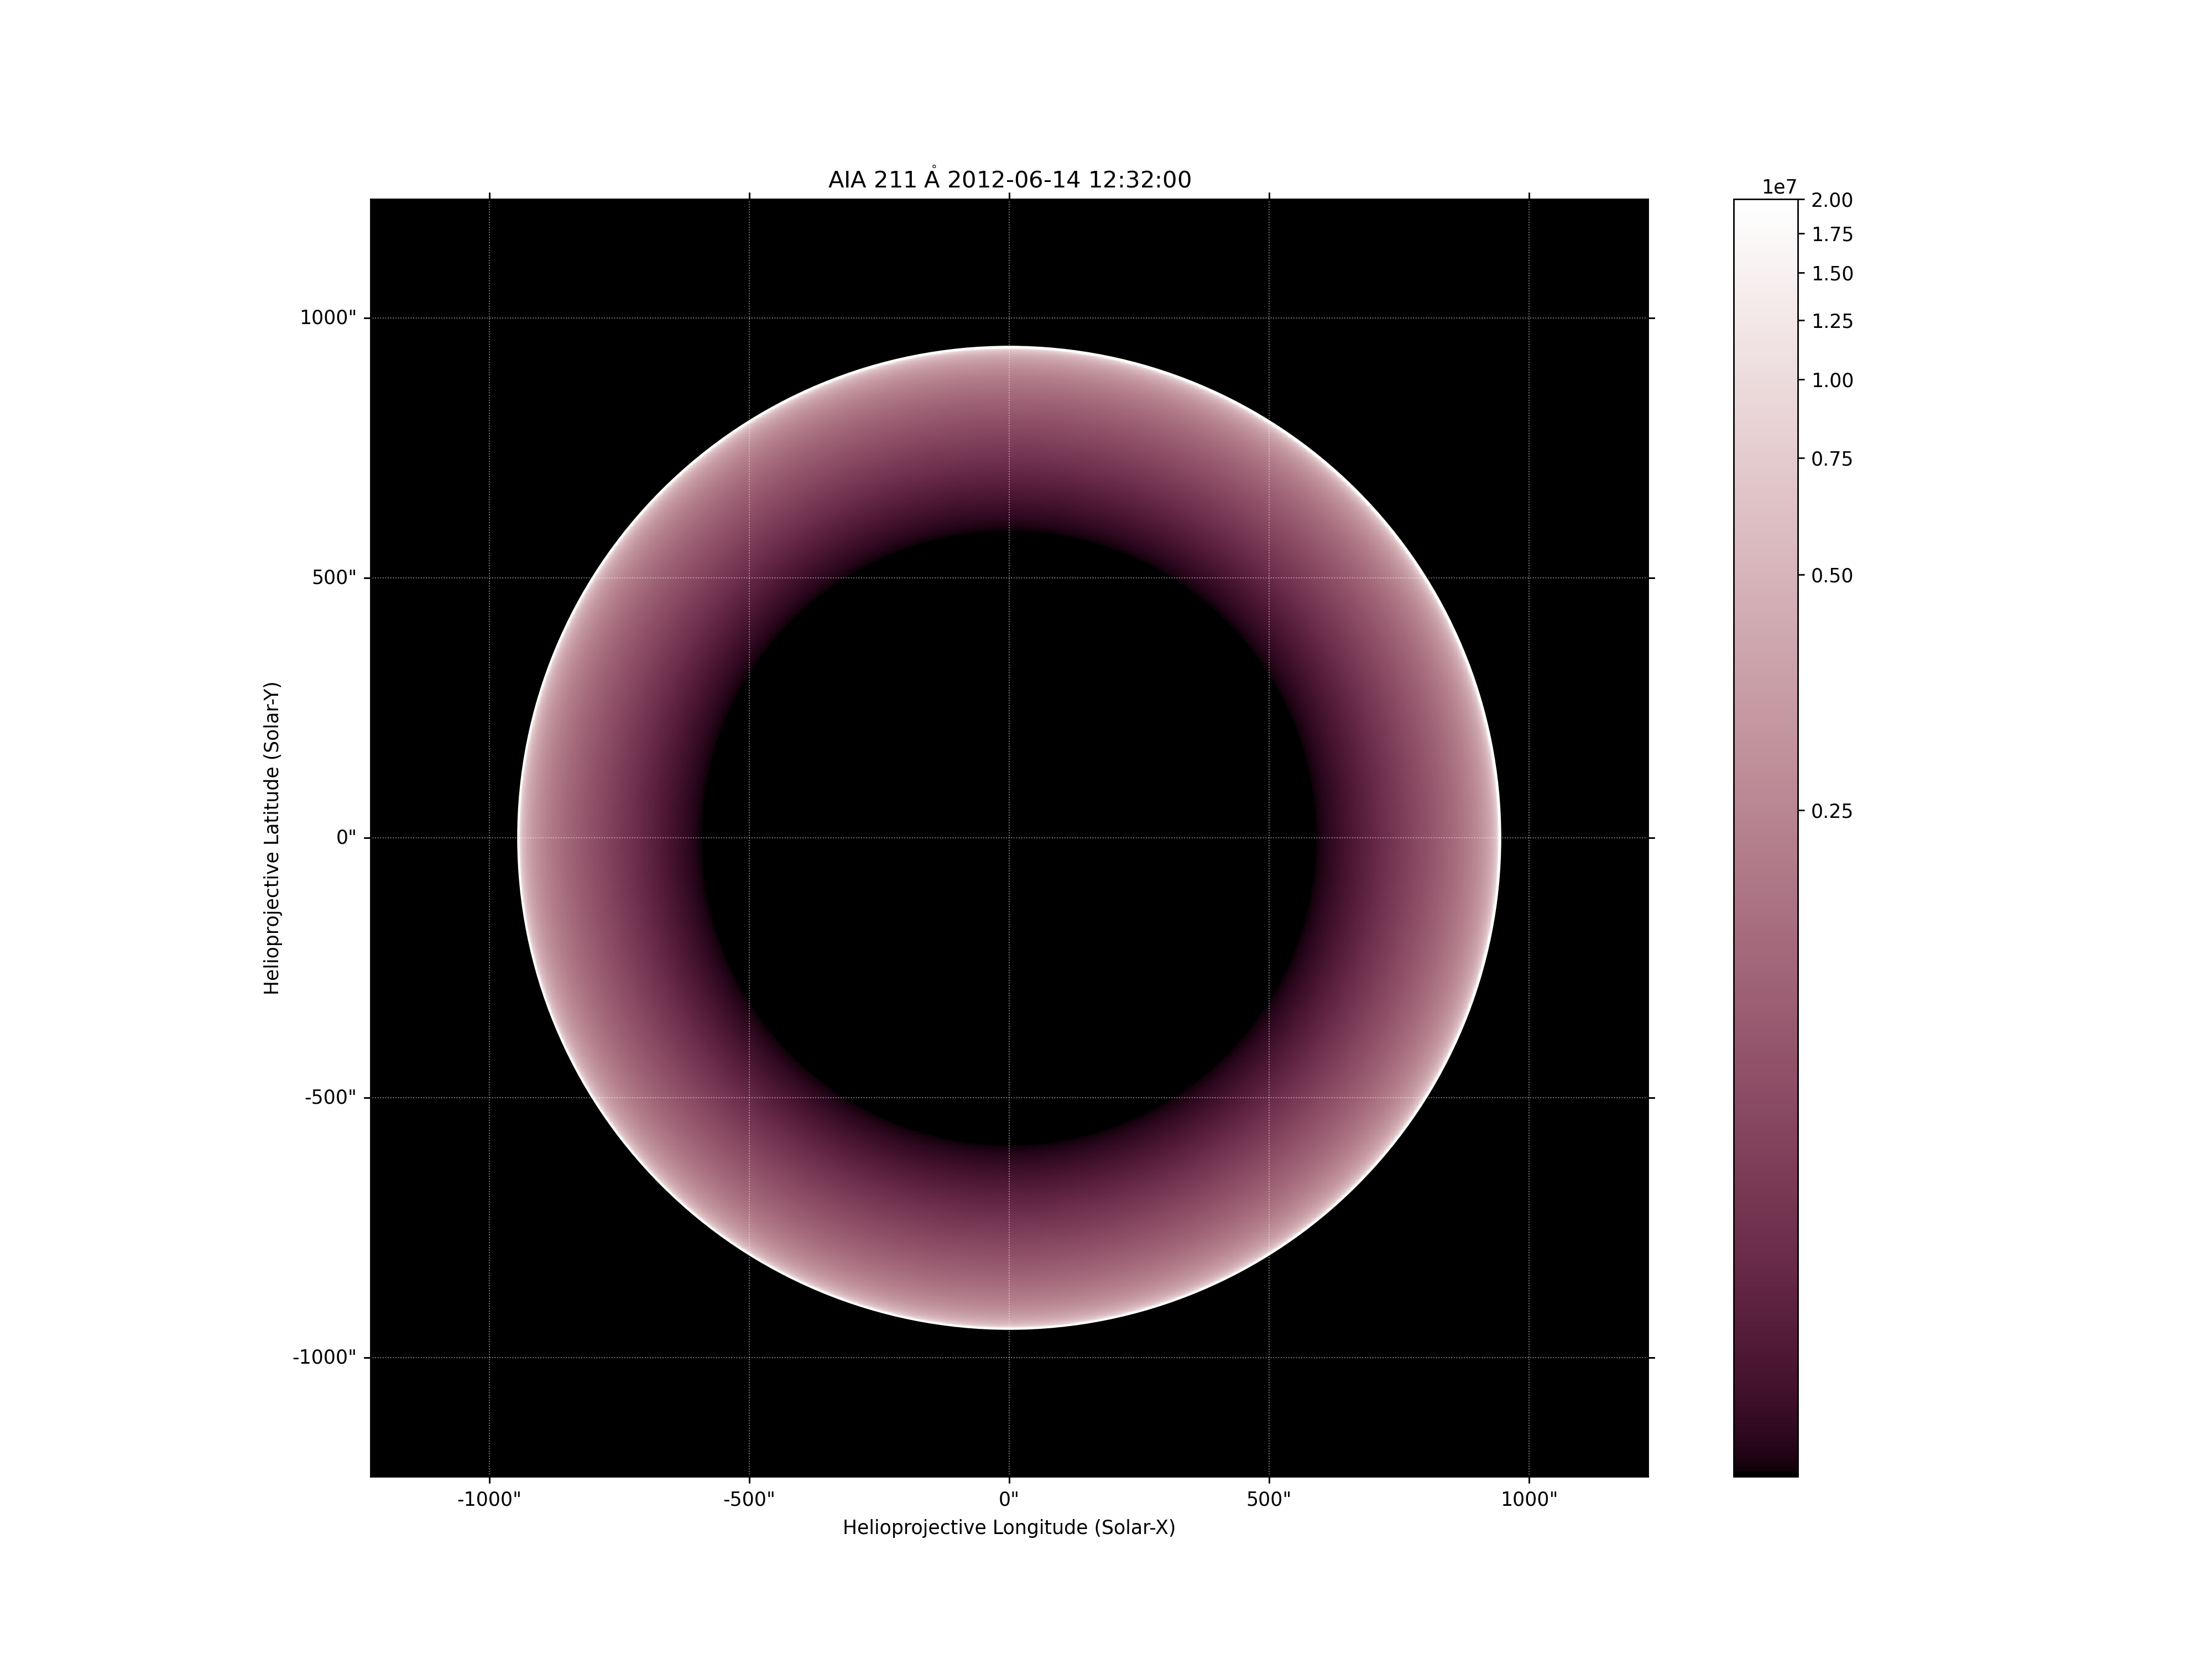

In [7]:
# for i in range(1,len(BD_img)):
for i in range(1,2):

    area_map = surface_map(BD_img[i])
    area_max= np.max(area_map.data)
    
    plt.figure()
    ax = plt.subplot(projection= area_map)
    area_map.plot(vmin=1e6, vmax=2e7)
    area_map.draw_limb()
    plt.colorbar() 
    
#     print(np.argwhere(~(area_map.data==area_map.data)))
#     print(area_map.data[np.argwhere(~(area_map.data==area_map.data))])
    
    time_map=parse_time(area_map.meta["date-obs"])
    time_string=time_map.strftime("%Y%m%d-%H-%M-%S")
    time_string=time_string[:-3]
    write_file(event+'/surface_map.fits'.format(string=time_string),area_map.data, area_map.meta,'fits')


In [14]:
df= pd.read_csv(event+'/dimming_data.csv', index_col=0, parse_dates=True)
df["Time"] = pd.to_datetime(df["Time"] )


area_list=[]
map_area = {}

for i in range(len(BD_img)):
# for i in range(4,5):
    ## surface area image
    surf= sunpy.map.Map(event+'/surface_map.fits')
    ## crop the surface image so that it matches the coordinates of the cropped images

    surf_map= cropping(surf, top, bottom, vmin=1e5, vmax=1e6)
    tot_area= np.sum(surf_map.data)
    
    ## create masked map
    smap= surf_map
    size1, size2= smap.data.shape
    print(smap.data.shape, seg_img[i].data.shape)
    masked_img = masking_nan(smap, seg_img[i])  
#     if i<3:
#         plt.figure()
#         masked_img.plot()
        
    area = np.sum(masked_img.data[masked_img.data==masked_img.data])
    area_list.append(area)
    perc_surf= area/tot_area*100
    perc_pix= len(masked_img.data[~np.isnan(masked_img.data)]) / (size1*size2) *100
    
    map_area[i]={'Date': masked_img.meta['date-obs'][:-3], 'Area value [km^2]': area,
                 'Surface percent [%]': perc_surf, 'Pixel perc [%]': perc_pix}


print('Total area: ', tot_area, 'km^2')
    
# print(map_area)
df['Area']= area_list
df.to_csv(event+'/dimming_data_a+b.csv')

Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min

Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min

Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  74752

Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min

Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  74752

Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  74752

Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
Total area:  207559055905.7831 km^2


In [15]:
# df= pd.read_csv('D:/POLIMI/THESIS/.fits_files/2011_09_06-211A-dimming_validation/area_map_data.csv', index_col=0, parse_dates=True)
df= pd.read_csv(event+'/dimming_data_a+b.csv', index_col=0, parse_dates=True)
df["Time"] = pd.to_datetime(df["Time"] )
# print(df)

df_plot=df.copy()
df_plot['Area'] = df_plot['Area']/10e9

fig = go.Figure(layout=go.Layout(height=500, width=1000))

# Plot Area evolution
fig.add_trace(go.Scatter(x=df_plot['Time'], y=df_plot['Area'], 
                         mode='lines', line = dict(color='#636EFA'),legendgroup="off-limb",name='Off-limb'))

fig.update_layout(title='Area evolution over time (cropped image)<br>'+event_time,title_x=0.5, title_font=dict(size=21, family='Arial'),
                  width=1000, height=600,template="plotly_white")

fig.update_yaxes(title_text='Dimming Area [10<sup>9</sup> km<sup>2</sup>]', mirror=True, ticks='inside',
                 zeroline=False,showline=True,linewidth=2,title_font=dict(size=18, family='Arial'),color='black',
                 tickwidth=2,tickfont=dict(size=18),linecolor='black',showgrid=False )

fig.update_xaxes(showgrid=False, showline=True, mirror=True, linecolor='black',tickwidth=2,
                 linewidth=2,nticks=8, ticks='inside')
#                  ,title_text="Date time (UT)",   , tickformat="%H:%M",title_font=dict(size=16, family='Arial'),tickfont=dict(size=1))

# fig.add_vline(x= df_plot['Time'][df_plot['Area'].idxmax()], line_dash="dash", line_width=1, line_color="black")
fig.add_vline(x=flare_time, line_dash="dash", line_width=1, line_color="black")
if flare_time=='2011-09-06 22:22:00.630':
    fig.add_vline(x='2011-09-07 22:38:00.630', line_dash="dash", line_width=1, line_color="black")
    fig.add_vline(x='2011-09-08 15:36:00.630', line_dash="dash", line_width=1, line_color="black")

fig.show()
fig.write_image(event+'/images/Area_evolution.png')

### Fixed mask area

Women's day event: 50933954346.71253


In [6]:
surf= sunpy.map.Map(event+'/surface_map.fits')
## crop the surface image so that it matches the coordinates of the cropped images

surf_map= cropping(surf, top, bottom, vmin=1e5, vmax=1e6)

## create masked map
smap= surf_map
size1, size2= smap.data.shape
print(smap.data.shape, seg_img[larg].data.shape)
masked_img = masking_nan(smap, seg_img[larg])  

area = np.sum(masked_img.data[masked_img.data==masked_img.data])
print(area)


Cropped Image
Mean value:  823633.9736900332 
 Max value:  1042376.8376963044 
 Min value:  747527.100883373
(502, 502) (502, 502)
50933954346.71253
